<a href="https://colab.research.google.com/github/iambrookedrake/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Brooke_Drake_DSPT6_U2S3M3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [182]:
##From source:: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00445/Absenteeism_at_work_AAA.zip

--2020-06-10 04:27:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00445/Absenteeism_at_work_AAA.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66136 (65K) [application/x-httpd-php]
Saving to: ‘Absenteeism_at_work_AAA.zip.2’

Absenteeism_at_work 100%[===================>]  64.59K  --.-KB/s    in 0.06s   

2020-06-10 04:27:43 (1.06 MB/s) - ‘Absenteeism_at_work_AAA.zip.2’ saved [66136/66136]



In [183]:
! unzip Absenteeism_at_work_AAA.zip

Archive:  Absenteeism_at_work_AAA.zip
replace Absenteeism_at_work.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Absenteeism_at_work.arff  
  inflating: Absenteeism_at_work.csv  
  inflating: Absenteeism_at_work.xls  
  inflating: Attribute Information.docx  
  inflating: UCI_ABS_TEXT.docx       


In [184]:
import pandas as pd
absent = pd.read_excel('Absenteeism_at_work.xls')
print(absent.shape)
absent.head()

(740, 21)


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,2


In [185]:
##Continue to clean and explore your data. 
absent = absent.rename(columns={'Son': 'Kids'})
absent['Vices'] = absent['Social drinker'] + absent['Social smoker'] + absent['Pet']
absent['Overweight'] = absent['Body mass index']>=25
absent['WorkToAge'] = (absent['Service time'] + (absent['Education']-1))/(absent['Age'])
absent['HalfDayOnly'] = absent['Absenteeism time in hours'] <=5
print(absent.shape)
absent.head()

(740, 25)


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Kids,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Vices,Overweight,WorkToAge,HalfDayOnly
0,11,26,7,3,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,4,2,True,0.393939,True
1,36,0,7,3,1,118,13,18,50,239554,97,1,1,1,1,0,0,98,178,31,0,1,True,0.360000,True
2,3,23,7,4,1,179,51,18,38,239554,97,0,1,0,1,0,0,89,170,31,2,1,True,0.473684,True
3,7,7,7,5,1,279,5,14,39,239554,97,0,1,2,1,1,0,68,168,24,4,2,False,0.358974,True
4,11,23,7,5,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,2,2,True,0.393939,True


In [186]:
absent = absent[absent['Absenteeism time in hours']>0] #because no one requests 0 hours off
absent = absent.drop(columns=['Month of absence','Work load Average/day ','Hit target',
                              'Disciplinary failure','Social drinker',
                              'Social smoker','Pet','Weight','Height',
                              'Body mass index','Service time','Age', 
                              'Day of the week','Seasons','Transportation expense',
                              'Education'], axis=1)
print(absent.shape)
absent.head()

(696, 9)


,ID,Reason for absence,Distance from Residence to Work,Kids,Absenteeism time in hours,Vices,Overweight,WorkToAge,HalfDayOnly
0,11,26,36,2,4,2,True,0.393939,True
2,3,23,51,0,2,1,True,0.473684,True
3,7,7,5,2,4,2,False,0.358974,True
4,11,23,36,2,2,2,True,0.393939,True
5,3,23,51,0,2,1,True,0.473684,True


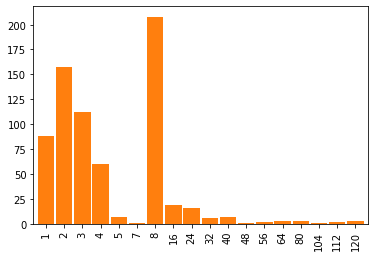

In [187]:
##Make exploratory visualizations.
absent['Absenteeism time in hours'].value_counts().sort_index().plot.bar(color='C1', width=0.9);

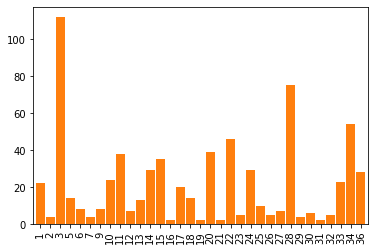

In [188]:
absent['ID'].value_counts().sort_index().plot.bar(color='C1', width=0.9);

In [189]:
import numpy as np
table = pd.pivot_table(absent, values='Absenteeism time in hours', index=['ID'],
                    columns=['HalfDayOnly'], aggfunc=np.sum, fill_value=0)

table

HalfDayOnly,False,True
ID,,
1,88,33
2,24,1
3,272,210
5,96,8
6,72,0
7,24,6
9,256,6
10,175,11
11,432,18


In [190]:
total = table
total.reset_index(level=total.index.names, inplace=True)
total['DayParts']=(0.5*total[True])+total[False]
total['Liklihood']=(total['DayParts']/total['DayParts'].mean())
total.sort_values(by=['DayParts'],ascending=False)


HalfDayOnly,ID,False,True,DayParts,Liklihood
11,14,440,36,458.0,3.273200
8,11,432,18,441.0,3.151705
2,3,272,210,377.0,2.694315
31,34,248,96,296.0,2.115430
32,36,272,39,291.5,2.083270
25,28,200,147,273.5,1.954629
17,20,224,82,265.0,1.893882
6,9,256,6,259.0,1.851002
21,24,232,22,243.0,1.736654
12,15,184,69,218.5,1.561559


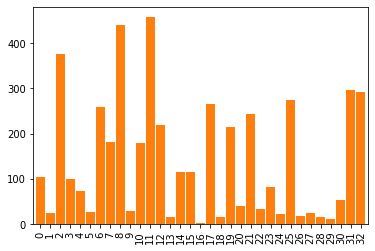

In [191]:
total.sort_values(by=['ID'],ascending=False)['DayParts'].sort_index().plot.bar(color='C1', width=0.9);

In [192]:
requests = pd.DataFrame(total['ID'])
requests['Liklihood'] = total['Liklihood']
requests

,ID,Liklihood
0,1,0.746833
1,2,0.175095
2,3,2.694315
3,5,0.714672
4,6,0.514564
5,7,0.192962
6,9,1.851002
7,10,1.289984
8,11,3.151705
9,12,0.207255


In [193]:
possible = absent.merge(requests)
possible.shape

(696, 10)

In [194]:
possible.tail(10)

,ID,Reason for absence,Distance from Residence to Work,Kids,Absenteeism time in hours,Vices,Overweight,WorkToAge,HalfDayOnly,Liklihood
686,12,19,51,1,8,9,False,0.064516,False,0.207255
687,12,22,51,1,8,9,False,0.064516,False,0.207255
688,12,22,51,1,3,9,False,0.064516,True,0.207255
689,12,19,51,1,2,9,False,0.064516,True,0.207255
690,29,28,15,2,2,3,True,0.439024,True,0.132214
691,29,19,15,2,3,3,True,0.439024,True,0.132214
692,29,14,15,2,8,3,True,0.439024,False,0.132214
693,29,22,15,2,8,3,True,0.439024,False,0.132214
694,16,23,15,2,8,2,True,0.521739,False,0.114348
695,16,7,15,2,8,2,True,0.521739,False,0.114348


In [195]:
possible = possible.drop(columns=['ID','Absenteeism time in hours'], axis=1)
possible.shape

(696, 8)

In [196]:
possible.dtypes

Reason for absence                   int64
Distance from Residence to Work      int64
Kids                                 int64
Vices                                int64
Overweight                            bool
WorkToAge                          float64
HalfDayOnly                           bool
Liklihood                          float64
dtype: object

In [197]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(possible, train_size=0.80, test_size=0.20, random_state=42)#
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=43)
train.shape, val.shape, test.shape

((444, 8), (112, 8), (140, 8))

In [198]:
###Fit a model. Does it beat your baseline? 
import sys
!pip install category_encoders==2.*
!pip install eli5
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, f_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

target = 'HalfDayOnly'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_classif, k=3), 
    LogisticRegression()
)
pipeline.fit(X_train, y_train)
k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k)
print()
print(f'MAE for {k} folds:', -scores)
print('Validation Accuracy', pipeline.score(X_val, y_val))



MAE for 3 folds: [-0.72297297 -0.67567568 -0.77027027]
Validation Accuracy 0.8125


In [199]:
y_train.shape, y_val.shape

((444,), (112,))

In [200]:
##Try xgboost.
import sys
!pip install category_encoders==2.*
!pip install eli5

import category_encoders as ce
#from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_val)
print()
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')


Validation accuracy: 0.7946428571428571


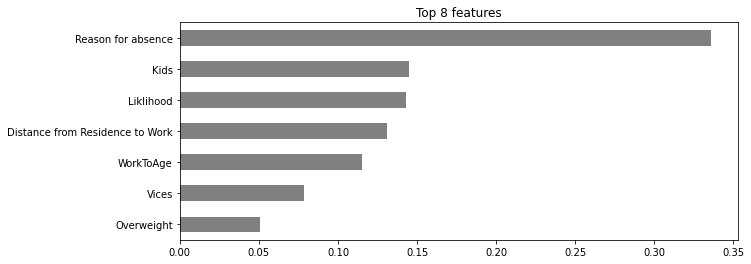

In [201]:
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 8
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [202]:
## Fit a model. Does it beat your baseline? 

import sys
!pip install category_encoders==2.*
!pip install eli5

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier



In [203]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_val)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.7946428571428571


In [204]:
##Get your model's permutation importances.

transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [205]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [206]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Liklihood                         -0.017857
Vices                             -0.016071
WorkToAge                         -0.007143
Distance from Residence to Work   -0.001786
Kids                              -0.001786
Overweight                         0.005357
Reason for absence                 0.228571
dtype: float64

In [207]:
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2286 ± 0.0416,Reason for absence
0.0054 ± 0.0087,Overweight
-0.0018 ± 0.0346,Kids
-0.0018 ± 0.0175,Distance from Residence to Work
-0.0071 ± 0.0134,WorkToAge
-0.0161 ± 0.0071,Vices
-0.0179 ± 0.0113,Liklihood
